#  Setup


If you are running locally(i.e. in a jupyter notebook in conda, just make sure you installed:
- RDKit
- DeepChem 2.5.0 & above
- Tensorflow 2.4.0 & above

Then, please skip the following part and continue from `Data Preparations`.

To increase efficiency, we recommend running in Colab.

Then, we'll first need to run the following lines of code, these will download conda with the deepchem environment in colab.

In [1]:
#!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
#import conda_installer
#conda_installer.install()
#!/root/miniconda/bin/conda info -e

In [2]:
#!pip install --pre deepchem
#import deepchem
#deepchem.__version__

# Data Preparations

Now we are ready to import some useful functions/packages, along with our model.

### Import Data

In [3]:
import FancyModule##our model

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import deepchem as dc 

### Select subset for training

Here, for demonstration, we'll be selecting a subset of size $2405$ from this in-vitro assay that detects inhibition of SARS-CoV 3CL protease via fluorescence.

The dataset is originally from [PubChem AID1706](https://pubchem.ncbi.nlm.nih.gov/bioassay/1706), previously handled by [JClinic AIcure](https://www.aicures.mit.edu/) team at MIT into this [binarized label form](https://github.com/yangkevin2/coronavirus_data/blob/master/data/AID1706_binarized_sars.csv).

In [7]:
df = pd.read_csv('AID1706_binarized_sars.csv')

In [8]:
df_false = df[df['activity']==0].sample(n=2000, replace = False)#s
df_true = df[df['activity'] == 1]
df_subset = pd.concat([df_false, df_true], ignore_index = True)

In [9]:
df_subset

,smiles,activity
0,C1=CC=C(C=C1)C2=CN(C3=NC=NC(=C23)NCCOCCO)C4=CC...,0
1,CC1=CC=C(C=C1)NC(=O)CSC2=NN=C(N2C3=CC=CC=C3)C,0
2,CC1CCN(CC1)CC(COC2=CC=C(C=C2)F)O,0
3,CC1=C(SC=[N+]1CC2=CC=CC=C2)CCOC(=O)C34CC5CC(C3...,0
4,C1=CC=C(C(=C1)C2=CC=CC=C2C(=O)O)C(=O)NC3=CC=CC...,0
...,...,...
2400,C1COC2=C(O1)C=CC(=C2)NC(=O)C3=C(OC=N3)C4=CC=CC=C4,1
2401,COC(=O)C1=CC=CC=C1NC(=O)C2=CC3=C(C=C2)OCCCO3,1
2402,COC1=CC=CC=C1CCNC(=O)C(=O)NCC2N(CCO2)S(=O)(=O)...,1
2403,CN(C)CCNC(=O)C(=O)NCC1N(CCO1)S(=O)(=O)C2=CC=C(...,1


Observe the dataframe above, it contains a 'smiles' column, which stands for the smiles representation of the molecules. There is also an 'activity' column, in which it is the label specifying whether that molecule is considered as hit for the protein.

### Set Minimum Length for molecules

Since we'll be using graphic representation for each molecules, we'll first need to cast the molecules into one universal length to fit into our training model. Our module contains a preparation function `prepare_data` that eliminates molecules shorter than the desired size.

In [10]:
df_minlength, y = FancyModule.prepare_data(df_subset, 12)

### Featurization

Our module also have a `featurize` function that represents the molecules in graphic format that is supported by out model.

The main structure of the featurizer could be referred from [here](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#deepchem.feat.MolGraphConvFeaturizer). 

Supported with **input_df**, the function would return featurized **node** and **edges**.

In [11]:
nodes, edges = FancyModule.featurize(df_minlength['smiles'])

# Training

Now, we're finally ready for training. We'll first import some necessary functions from tensorflow.

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Here we'll first initiate a  model with the corresponding `make_model` functions in the package.

In [13]:
model = FancyModule.make_model()

Now we'll train the model with the above subset and plot out the training curve.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit([np.array(nodes), np.array(edges)],
                    y,
                    epochs=80, 
                    verbose = False,
                    #class_weight=class_weights
                    #steps_per_epoch = 100,
                    )

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'training accuracy')]

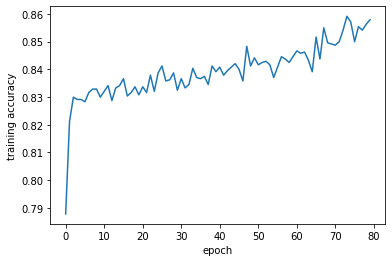

In [15]:
plt.plot(history.history["accuracy"])
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

# Testing (Payoff)

Here, we'll demonstrate the testing phase(thoroughput screening) with a newly random selected subset from the above mentioned SARS-CoV 3CL protease assay.

In [16]:
df_false = df[df['activity']==0].sample(n=2000, replace = False)#s

df_test_subset = pd.concat([df_false, df_true], ignore_index = True)

The testing function accepts three parameters: the testing column of molecules in smiles format, trained model, and True/False statement of whether to save the result in the directory(default False).

In [17]:
FancyModule.test(df_test_subset['smiles'], model)

,smiles,prediction
0,CC1=C(OC2=CC=CC=C12)C(=O)N3CCCCCC3,0.082688
1,CCN1C(=NN=C1SCC(=O)NC2=NOC(=C2)C)C3=CC=C(C=C3)...,0.089236
2,CCN(CC)C1=CC=C(C=C1)/C=C\2/C(=NN(C2=O)C3=NN=C(...,0.210360
3,CCN(CC)C(=O)CSC1=C(C(=CC(=N1)C2=CC=CS2)C3=CC=C...,0.300189
4,CC1=C(C(=O)N(N1)C2=NC(=CS2)C3=CC=C(C=C3)Cl)N=N...,0.222906
...,...,...
2400,C1COC2=C(O1)C=CC(=C2)NC(=O)C3=C(OC=N3)C4=CC=CC=C4,0.291296
2401,COC(=O)C1=CC=CC=C1NC(=O)C2=CC3=C(C=C2)OCCCO3,0.141142
2402,COC1=CC=CC=C1CCNC(=O)C(=O)NCC2N(CCO2)S(=O)(=O)...,0.360332
2403,CN(C)CCNC(=O)C(=O)NCC1N(CCO1)S(=O)(=O)C2=CC=C(...,0.459097


Yay, now we have 

## Drafts

In [18]:
smiles = ["C1CCC1", "C1=CC=CN=C1"]
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
out = featurizer.featurize(smiles)




In [20]:

out[0].node_features.sum(axis = 0)


array([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 4., 0., 0., 0.])

In [23]:
out[1].node_features

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [ ]:
test_df.take([272])['smiles']

In [ ]:

len(t[1].node_features.sum(axis = 0))


In [ ]:
mo.predict([np.array(fn), np.array(fe)])


In [ ]:
len(t[0].edge_features.sum(axis = 0))


In [ ]:
pd =test_df['smiles'] + test_df['results'].map(str) 

In [ ]:
pd.to_csv('cat.csv')

In [ ]:
test_df.sort_values(by='results',ascending = False)

In [ ]:
test_df.to_csv('cool.csv')

In [ ]:
directory_path

In [ ]:
import os
directory_path = os.getcwd()